## Learning Inverted Pendulum Using Reinforcement Learning 

![SegmentLocal](pendulum.gif "segment")


## Part 1 Introduction

In this task, we are going to train a neural network policy for inverted pendulum using reinforcement learning. 
The inverted pendulum swingup problem is based on the classic problem in control theory. The system consists of a pendulum attached at one end to a fixed point, and the other end being free. The pendulum starts in a random position and the goal is to apply torque on the free end to swing it into an upright position, with its center of gravity right above the fixed point. The diagram below specifies the coordinate system used for the implementation of the pendulum's dynamic equations.


### Action Space
The action is a `ndarray` with shape `(1,)` representing the torque applied to free end of the pendulum.

| Num | Action | Min  | Max |
|-----|--------|------|-----|
| 0   | Torque | -2.0 | 2.0 |

### Observation Space
The observation is a `ndarray` with shape `(3,)` representing the x-y coordinates of the pendulum's free
end and its angular velocity.

| Num | Observation      | Min  | Max |
|-----|------------------|------|-----|
| 0   | x = cos(theta)   | -1.0 | 1.0 |
| 1   | y = sin(theta)   | -1.0 | 1.0 |
| 2   | Angular Velocity | -8.0 | 8.0 |

### Rewards

The reward function is defined as:
$$r = -(theta^2 + 0.1 * \hat{theta}^2 + 0.001 * torque^2)$$

where $\theta$ is the pendulum's angle normalized between $[-pi, pi]$ (with 0 being in the upright position).

(You don't need to define the reward. It is provided by the OpenAI Gym environment)

### Starting State

The starting state is a random angle in *[-pi, pi]* and a random angular velocity in *[-1,1]*.

### Episode Truncation
The episode truncates at 200 time steps.

## Part 2: Implementation


### Import python packages 


We will use **OpenAI Gym** as our simulator. Gym is an open source Python library for developing and comparing reinforcement learning algorithms by providing a standard API to communicate between learning algorithms and environments, as well as a standard set of environments compliant with that API. Since its release, Gym's API has become the field standard for doing this.

In [2]:
import gym # gym.__version__ = 0.20.0
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Normal
import numpy as np

### Hyperparameters

We provide some default hyperparameters. Note that RL is very sensitive to hyperparameters. Feel free to modify the them. 

In [3]:
#Hyperparameters
learning_rate  = 0.0003
gamma           = 0.9
lmbda           = 0.9
eps_clip        = 0.2
K_epoch         = 10
rollout_len    = 3
buffer_size    = 30
minibatch_size = 32

## Your Task

Your trask is to implement a policy gradient algorithm for the task of inverted pendulum. 


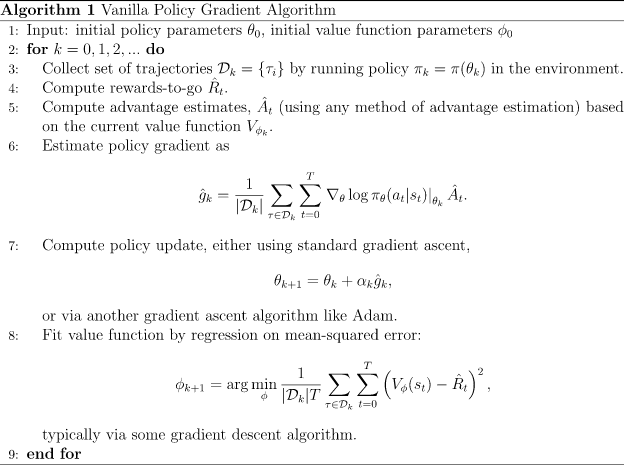


In [4]:
class RLAgent(nn.Module):
    def __init__(self):
        super(RLAgent, self).__init__()
        self.data = []
        
        
        self.fc1   = nn.Linear(3,128)
        self.fc_mu = nn.Linear(128,1)
        self.fc_std  = nn.Linear(128,1)
        self.fc_v = nn.Linear(128,1)
        
        # Define network optimizer for updating the parameters
        self.optimizer = optim.Adam(self.parameters(), lr=learning_rate)
        self.optimization_step = 0

    def pi(self, x, softmax_dim = 0):
        # # Policy network 
        # observation dimension = 3
        # action dimension = 1
        x = F.relu(self.fc1(x))
        
        # the mean action
        mu = 2.0*torch.tanh(self.fc_mu(x))
        
        # the action exploration (state-dependent exploration)
        std = F.softplus(self.fc_std(x))
        return mu, std
    
    def v(self, x):
        # # Value function
        x = F.relu(self.fc1(x))
        v = self.fc_v(x)
        return v
      
    def put_data(self, transition):
        self.data.append(transition)
        
    def make_batch(self):
        s_batch, a_batch, r_batch, s_prime_batch, prob_a_batch, done_batch = [], [], [], [], [], []
        data = []

        for j in range(buffer_size):
            for i in range(minibatch_size):
                rollout = self.data.pop()
                s_lst, a_lst, r_lst, s_prime_lst, prob_a_lst, done_lst = [], [], [], [], [], []

                for transition in rollout:
                    s, a, r, s_prime, prob_a, done = transition
                    
                    s_lst.append(s)
                    a_lst.append([a])
                    r_lst.append([r])
                    s_prime_lst.append(s_prime)
                    prob_a_lst.append([prob_a])
                    done_mask = 0 if done else 1
                    done_lst.append([done_mask])

                s_batch.append(s_lst)
                a_batch.append(a_lst)
                r_batch.append(r_lst)
                s_prime_batch.append(s_prime_lst)
                prob_a_batch.append(prob_a_lst)
                done_batch.append(done_lst)
                    
            mini_batch = torch.tensor(s_batch, dtype=torch.float), torch.tensor(a_batch, dtype=torch.float), \
                          torch.tensor(r_batch, dtype=torch.float), torch.tensor(s_prime_batch, dtype=torch.float), \
                          torch.tensor(done_batch, dtype=torch.float), torch.tensor(prob_a_batch, dtype=torch.float)
            data.append(mini_batch)

        return data

    def calc_advantage(self, data):
        data_with_adv = []
        for mini_batch in data:
            s, a, r, s_prime, done_mask, old_log_prob = mini_batch
            with torch.no_grad():
                td_target = r + gamma * self.v(s_prime) * done_mask
                delta = td_target - self.v(s)
            delta = delta.numpy()

            advantage_lst = []
            advantage = 0.0
            for delta_t in delta[::-1]:
                advantage = gamma * lmbda * advantage + delta_t[0]
                advantage_lst.append([advantage])
            advantage_lst.reverse()
            advantage = torch.tensor(advantage_lst, dtype=torch.float)
            data_with_adv.append((s, a, r, s_prime, done_mask, old_log_prob, td_target, advantage))

        return data_with_adv

        
    def train_net(self):
        if len(self.data) == minibatch_size * buffer_size:
            data = self.make_batch()
            
            # compute advantage function
            data = self.calc_advantage(data)

            for i in range(K_epoch):
                for mini_batch in data:
                    s, a, r, s_prime, done_mask, old_log_prob, td_target, advantage = mini_batch
                    
                    # ====================== This is your task ============================
                    #
                    # Please implement the policy update here using policy gradient. 
                    # 
                    # TODOs: 
                    # Step 1: compute loss 
                    # Step 2: update network parameters via backward propagation


In [ ]:
env = gym.make('Pendulum-v0')
model = RLAgent()
score = 0.0
print_interval = 20
rollout = []

for n_epi in range(10000):
    s = env.reset()
    done = False
    while not done:
        for t in range(rollout_len):
            # compute mean and std
            mu, std = model.pi(torch.from_numpy(s).float())
            dist = Normal(mu, std)
            
            # sample control command
            a = dist.sample()
            log_prob = dist.log_prob(a)
            
            # simulate the environment. 
            s_prime, r, done, info = env.step([a.item()])

            # collect data 
            rollout.append((s, a, r/10.0, s_prime, log_prob.item(), done))
            if len(rollout) == rollout_len:
                model.put_data(rollout)
                rollout = []

            s = s_prime
            score += r
            if done:
                break

        # Network training. 
        # ====================== This is your task ============================
        model.train_net()

    if n_epi%print_interval==0 and n_epi!=0:
        print("Number of episode :{}, avg score : {:.1f}, opt step: {}".format(n_epi, score/print_interval, model.optimization_step))
        score = 0.0

env.close()

/tmp/ipykernel_87345/1967953998.py:65: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:210.)
  mini_batch = torch.tensor(s_batch, dtype=torch.float), torch.tensor(a_batch, dtype=torch.float), \


# of episode :20, avg score : -1260.8, opt step: 300
# of episode :40, avg score : -1217.0, opt step: 600
# of episode :60, avg score : -1170.6, opt step: 1200
# of episode :80, avg score : -1198.3, opt step: 1500
# of episode :100, avg score : -1260.2, opt step: 2100
# of episode :120, avg score : -1288.9, opt step: 2400
# of episode :140, avg score : -1134.5, opt step: 2700
# of episode :160, avg score : -1173.0, opt step: 3300
# of episode :180, avg score : -1124.1, opt step: 3600
# of episode :200, avg score : -1087.9, opt step: 3900
# of episode :220, avg score : -1000.8, opt step: 4500
# of episode :240, avg score : -987.9, opt step: 4800
# of episode :260, avg score : -1090.5, opt step: 5400
# of episode :280, avg score : -1105.2, opt step: 5700
# of episode :300, avg score : -1094.0, opt step: 6000
# of episode :320, avg score : -1138.4, opt step: 6600
# of episode :340, avg score : -1098.1, opt step: 6900
# of episode :360, avg score : -1144.7, opt step: 7500
# of episode :380

The agv score (reward) should be increasing 

In [11]:
# Evaluate your policy after training
s = env.reset()
done = False
while not done:
    for t in range(rollout_len):
        # compute mean and std
        mu, std = model.pi(torch.from_numpy(s).float())
        # simulate the environment. 
        s, _, done, _ = env.step([mu.item()])
        
        env.render()
env.close()